## FDTree Class

In [1]:
import time
import klepto
import shelve
import pickle
import h5py
import numpy as np
from scipy.sparse import *
import matplotlib.pyplot as plt

In [2]:
dataset = '20m'

In [3]:
feature=h5py.File('movielens/test_list.mat')  
test_list = feature['test_list'][:]
test_list = list(map(int, test_list.T[0]))
test_list = [i-1 for i in test_list] 
feature=h5py.File('movielens/train_list.mat')  
train_list = feature['train_list'][:]
train_list = list(map(int, train_list.T[0]))
train_list = [i-1 for i in train_list] 

In [6]:
rating_matrix_csc = load_npz('movielens/sparse_matrix_ml-' + dataset + '_selected.npz').tocsc()
rating_matrix_csc_train = rating_matrix_csc[:, train_list]
rating_matrix_csc_test  = rating_matrix_csc[:, test_list]
print("file load DONE")
depth_threshold = 8

file load DONE


## Step 1: Input Dataset

In [8]:
class DecisionTreeModel:
    def __init__(self, source, depth_threshold=10, plambda=7, MSP_item=200):
        
        self.sMatrix = source
        self.depth_threshold = depth_threshold
        self.plambda = plambda
        self.MSP_item = MSP_item

        #### Calculate rate of progress ####
        self.cur_depth = 0
        self.node_num = 0
        self.cur_node = 0
        for i in range(self.depth_threshold):
            self.node_num += 3 ** i
        
        #### Initiate Tree, lr_bound ####
        self.tree = list(range(self.sMatrix.shape[1]))
        self.split_item = []
        self.lr_bound = {'0': [[0, len(self.tree) - 1]]}

        #### Generate bias, sum_cur_t, sum_2_cur_t ####
        #### Generate rU ####        
        self.rU = {}        
        for dictname in range(int(self.sMatrix.shape[1]/5000) + 1):
            d = shelve.open('rU_data/'+str(dictname), protocol = pickle.HIGHEST_PROTOCOL)
            self.rU.update(d['content'])
            d.close()
        print("rU DONE")
        
        Tree = klepto.archives.dir_archive('treeFile', {}, serialized=True)
        Tree.load()
        self.biasU       = Tree["biasU"]
        self.sum_cur_t   = Tree["sum_cur_t"]
        self.sum_2_cur_t = Tree["sum_2_cur_t"]
        self.sum_cntt    = Tree["sum_cntt"]
        self.item_size = self.sMatrix.shape[0]
        self.user_size = len(self.tree)        
        self.MPS = []
        print("Initiation DONE!")

    def calculate_error(self, sumt, sumt_2, cntt):
        ''' Calculate error for one item-split in one node '''
        Error_i = np.sum(sumt_2 - (sumt ** 2) / (cntt + 1e-9))

        return Error_i

    def generate_decision_tree(self, lr_bound_for_node, chosen_id):
        #### Terminate ####
        self.cur_depth += 1
        if self.cur_depth > self.depth_threshold or len(chosen_id) == self.item_size:
            return   
        
        #### Choose Most Popular Items of This Node ####     
        num_rec = np.zeros(self.item_size)
        for userid in self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)]:
            user_all_rating_id = np.array(list(self.rU[userid].keys()))
            num_rec[user_all_rating_id] += 1
        MPS_item_id = list(np.argsort(-num_rec)[:])
        for item_id in chosen_id:
            MPS_item_id.remove(item_id)
        MPS_item_id = MPS_item_id[:self.MSP_item]
            
        #### Find optimum item to split ####
        min_sumtL, min_sumtD, min_sumtL_2, min_sumtD_2, min_sumtU, min_sumtU_2, Error = {}, {}, {}, {}, {}, {}, {}
        min_Error = "None"
        for itemid in MPS_item_id:
            if itemid in chosen_id:
                continue
            '''
                user_rating_item_in_nodet: np.array([ [uid01, rating01], [uid02, rating02], ... ])
                to find all users in node t who rates item i
            '''
            
            user_rating_item_in_nodet = np.array([[userid, self.rU[userid][itemid]] for userid in
                                         self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)] if
                                         itemid in self.rU[userid]])         
            sumt = np.zeros((self.item_size, 3))
            sumt_2 = np.zeros((self.item_size, 3))
            cntt = np.zeros((self.item_size, 3))
            for user in user_rating_item_in_nodet:
                ''' user_all_rating: array [ [itemid11, rating11], [itemid12, rating12], ... ] '''
                user_all_rating_id = np.array(list(self.rU[user[0]].keys()))
                user_all_rating = np.array(list(self.rU[user[0]].values()))
                #### calculate sumtL for node LIKE ####
                if user[1] > 3:
#                     split.setdefault(itemid, []).append(user[0])
                    sumt[user_all_rating_id[:], 0] += user_all_rating[:] - self.biasU[user[0]]
                    sumt_2[user_all_rating_id[:], 0] += (user_all_rating[:] - self.biasU[user[0]]) ** 2
                    cntt[user_all_rating_id[:], 0] += 1
                #### calculate sumtD for node DISLIKE ####
                elif user[1] <= 3:
                    sumt[user_all_rating_id[:], 1] += user_all_rating[:] - self.biasU[user[0]]
                    sumt_2[user_all_rating_id[:], 1] += (user_all_rating[:] - self.biasU[user[0]]) ** 2
                    cntt[user_all_rating_id[:], 1] += 1

            #### calculate sumtU for node UNKNOWN ####
            sumt[:, 2] = self.sum_cur_t[:] - sumt[:, 0] - sumt[:, 1]
            sumt_2[:, 2] = self.sum_2_cur_t[:] - sumt_2[:, 0] - sumt_2[:, 1]
            cntt[:, 2] = self.sum_cntt[:] - cntt[:, 0] - cntt[:, 1]
            Error[itemid] = self.calculate_error(sumt, sumt_2, cntt)
            if min_Error == "None" or Error[itemid] < min_Error:
                min_sumt = sumt
                min_sumt_2 = sumt_2
                min_cntt = cntt
                min_Error = Error[itemid]
        #### Find optimum split-item ####
        optimum_itemid = min(Error, key=Error.get)
        if len(self.split_item) == self.cur_depth - 1:
            self.split_item.append([optimum_itemid])
        else:
            self.split_item[self.cur_depth - 1].append(optimum_itemid)
        chosen_id.append(optimum_itemid)
#         print(Error)
        print("split item found!")
#         print(optimum_itemid)
        #### sort tree ####
        self.lr_bound.setdefault(str(self.cur_depth), []).append([])  # for LIKE
        self.lr_bound[str(self.cur_depth)].append([])  # for DISLIKE
        self.lr_bound[str(self.cur_depth)].append([])  # for UNKNOWN
        listU, listL, listD = [], [], []
        for userid in self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)]:
            if optimum_itemid not in self.rU[userid]:
                listU.append(userid)
            elif self.rU[userid][optimum_itemid] >= 4:
                listL.append(userid)
            elif self.rU[userid][optimum_itemid] <= 3:
                listD.append(userid)
        self.tree[lr_bound_for_node[0]:(lr_bound_for_node[1] + 1)] = listL + listD + listU
        self.lr_bound[str(self.cur_depth)][-3] = [lr_bound_for_node[0],
                                                  lr_bound_for_node[0] + len(listL) - 1]  # for LIKE
        self.lr_bound[str(self.cur_depth)][-2] = [lr_bound_for_node[0] + len(listL),
                                                  lr_bound_for_node[0] + len(listL) + len(listD) - 1]  # for DISLIKE
        self.lr_bound[str(self.cur_depth)][-1] = [lr_bound_for_node[0] + len(listL) + len(listD),
                                                  lr_bound_for_node[0] + len(listL) + len(listD) + len(listU) - 1]  # for UNKNOWN

        #### Generate Subtree of Node LIKE ####
        self.sum_cur_t = min_sumt[:, 0]
        self.sum_2_cur_t = min_sumt_2[:, 0]
        self.sum_cntt = min_cntt[:, 0]
        self.generate_decision_tree(self.lr_bound[str(self.cur_depth)][-3], chosen_id[:])
        self.cur_depth -= 1

        #### Generate Subtree of Node DISLIKE ####
        self.sum_cur_t = min_sumt[:, 1]
        self.sum_2_cur_t = min_sumt_2[:, 1]
        self.sum_cntt = min_cntt[:, 1]
        self.generate_decision_tree(self.lr_bound[str(self.cur_depth)][-2], chosen_id[:])
        self.cur_depth -= 1

        #### Generate Subtree of Node UNKNOWN ####
        self.sum_cur_t = min_sumt[:, 2]
        self.sum_2_cur_t = min_sumt_2[:, 2]
        self.sum_cntt = min_cntt[:, 2]
        self.generate_decision_tree(self.lr_bound[str(self.cur_depth)][-1], chosen_id[:])
        self.cur_depth -= 1

        #### Show Rating Progress ####
        for i in range(self.cur_depth - 1):
            print("┃", end="")
        print("┏", end="")
        self.cur_node += 1
        print("Current depth: " + str(self.cur_depth) + "        %.2f%%" % (100 * self.cur_node / self.node_num))

    def build_model(self):
        #### Construct the tree & get the prediction model ####
        self.generate_decision_tree(self.lr_bound['0'][0], [])

## Tree Init

In [9]:
dtmodel_realdata = DecisionTreeModel(rating_matrix_csc_train, depth_threshold)

rU DONE
Initiation DONE!


## Build Tree

In [ ]:
dtmodel_realdata.build_model()

split item found!
split item found!
split item found!
split item found!
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.03%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.06%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.09%
┃┃┃┃┃┃┏Current depth: 7        0.12%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.15%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.18%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.21%
┃┃┃┃┃┃┏Current depth: 7        0.24%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.27%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.30%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.34%
┃┃┃┃┃┃┏Current depth: 7        0.37%
┃┃┃┃┃┏Current depth: 6        0.40%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.43%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        0.46%
split item found!
┃┃┃┃┃┃┃┏Current depth

split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.51%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.54%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.57%
┃┃┃┃┃┃┏Current depth: 7        4.60%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.63%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.66%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.70%
┃┃┃┃┃┃┏Current depth: 7        4.73%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.76%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.79%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.82%
┃┃┃┃┃┃┏Current depth: 7        4.85%
┃┃┃┃┃┏Current depth: 6        4.88%
┃┃┃┃┏Current depth: 5        4.91%
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.94%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        4.97%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        5.00%
┃┃┃┃┃┃┏Current depth

split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.02%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.05%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.09%
┃┃┃┃┃┃┏Current depth: 7        9.12%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.15%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.18%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.21%
┃┃┃┃┃┃┏Current depth: 7        9.24%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.27%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.30%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.33%
┃┃┃┃┃┃┏Current depth: 7        9.36%
┃┃┃┃┃┏Current depth: 6        9.39%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.42%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.45%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        9.48%
┃┃┃┃┃┃┏Current depth: 7        9.51%
split item found!
split item found!


split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.45%
┃┃┃┃┃┃┏Current depth: 7        13.48%
┃┃┃┃┃┏Current depth: 6        13.51%
┃┃┃┃┏Current depth: 5        13.54%
split item found!
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.57%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.60%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.63%
┃┃┃┃┃┃┏Current depth: 7        13.66%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.69%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.72%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.75%
┃┃┃┃┃┃┏Current depth: 7        13.78%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.81%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.84%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        13.87%
┃┃┃┃┃┃┏Current depth: 7        13.90%
┃┃┃┃┃┏Current depth: 6        13.93%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8

split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        17.90%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        17.93%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        17.96%
┃┃┃┃┃┃┏Current depth: 7        17.99%
┃┃┃┃┃┏Current depth: 6        18.02%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.05%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.08%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.11%
┃┃┃┃┃┃┏Current depth: 7        18.14%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.17%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.20%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.23%
┃┃┃┃┃┃┏Current depth: 7        18.26%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.29%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.32%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        18.35%
┃┃┃┃┃┃┏Current depth: 7        18.38%
┃┃┃┃┃┏Current depth: 6        18.41%


split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.35%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.38%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.41%
┃┃┃┃┃┃┏Current depth: 7        22.44%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.47%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.50%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.53%
┃┃┃┃┃┃┏Current depth: 7        22.56%
┃┃┃┃┃┏Current depth: 6        22.59%
split item found!
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.62%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.65%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.68%
┃┃┃┃┃┃┏Current depth: 7        22.71%
split item found!
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.74%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.77%
split item found!
┃┃┃┃┃┃┃┏Current depth: 8        22.80%
┃┃┃┃┃┃┏Current depth: 7        22.84%
split item found!
split item found!
┃

In [ ]:
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)

Tree['lr_bound'] = dtmodel_realdata.lr_bound
Tree['tree'] = dtmodel_realdata.tree
Tree['split_item'] = dtmodel_realdata.split_item

Tree.dump()
Tree.clear()

In [ ]:
time.localtime(time.time())
time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))

In [72]:
del dtmodel_realdata

## MF part

In [38]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS

class MatrixFactorization:
    def __init__(self, maxIter=15, regParam=0.01, rank=10):
        self.maxIter = maxIter
        self.regParam = regParam
        self.rank = rank
        conf = SparkConf().setAppName("appName").setMaster("local[*]")
        conf.set("spark.driver.memory","8g")
        conf.set("spark.executor.memory","8g")
        self.spark = SparkContext(conf=conf)
                    
        print("New SparkSession started...")

    def change_parameter(self, regParam):
        self.regParam = regParam

    def matrix_factorization(self, train_lst):
        ratings = self.spark.parallelize(train_lst)
#         print('create dataframe!')
        model = ALS.train(ratings, self.rank, seed=10, \
                          iterations=self.maxIter, \
                          lambda_=self.regParam)
        print("MF DONE")
        userFeatures = sorted(model.userFeatures().collect(), key=lambda d: d[0], reverse=False)
        productFeatures = sorted(model.productFeatures().collect(), key=lambda d: d[0], reverse=False)
        userProfile = {each[0]: each[1].tolist() for each in userFeatures}
        itemProfile = {each[0]: each[1].tolist() for each in productFeatures}
        
        
        return userProfile, itemProfile

    def end(self):
        self.spark.stop()
        print("SparkSession stopped.")

## Load Tree from file

In [39]:
import klepto
import numpy as np
Tree = klepto.archives.dir_archive('treeFile', {}, serialized=True)
Tree.load()

In [40]:
def read_h5py(filename):
    with h5py.File(filename + ".mat") as data:
        file = [data[element[0]][:] for element in data[filename]]
    return file

In [41]:
split_item = read_h5py('split_item')
for i in range(len(split_item)):
    split_item[i].T[0] = split_item[i].T[0] - 1
    
lr_bound_list = read_h5py('lr_bound')

i = 0
for i in range(len(lr_bound_list)):
    level = lr_bound_list[i]
    lr_bound_list[i] = []
    level = list((level.T)[0])
    for boundNum in range(0, len(level), 2):
        lr_bound_list[i].append([int(level[boundNum]) - 1, int(level[boundNum + 1]) - 1])
    i += 1

lr_bound = {}
for i in range(len(lr_bound_list)):
    lr_bound[str(i)] = lr_bound_list[i]
    
feature=h5py.File('tree.mat')  
tree = list(feature['tree'][:].T[0])
tree = [i-1 for i in tree] 

In [42]:
lambda_list = [0.005, 0.01,  0.02,  0.04,  0.08, 0.16,  0.32,  0.64,  1.28]

In [75]:
split_item = Tree['split_item']
lr_bound = Tree['lr_bound']
tree = Tree['tree']
lambda_list = [0.005, 0.01,  0.02,  0.04,  0.08, 0.16,  0.32,  0.64,  1.28]#,  2.56, 5.12, 10.24, 20.48, 40.96, 81.92];
# lambda_list = [0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.25]

In [169]:
MF = MatrixFactorization()

New SparkSession started...


level: 0
Rating Number of level 0: 6040
Current plambda: 0.005
MF DONE
321187.915036
303382
Current RMSE: 1.02892730665
Current plambda: 0.01
MF DONE
321178.441206
303382
Current RMSE: 1.02891213181
Current plambda: 0.02
MF DONE
321163.439997
303382
Current RMSE: 1.02888810294
Current plambda: 0.04
MF DONE
321190.414201
303382
Current RMSE: 1.02893130969
Current plambda: 0.08
MF DONE
321798.589219
303382
Current RMSE: 1.02990499126
Current plambda: 0.16
MF DONE
326477.110154
303382
Current RMSE: 1.03736469587
Current plambda: 0.32
MF DONE
347977.336812
303382
Current RMSE: 1.07097806244
Current plambda: 0.64
MF DONE
433291.811346
303382
Current RMSE: 1.19507547973
Current plambda: 1.28
MF DONE
777795.210943
303382
Current RMSE: 1.60117104313
min RMSE: 1.02888810294


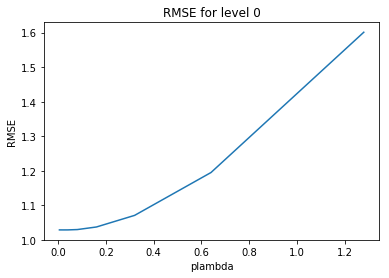

level: 1
Rating Number of level 1: 17960
Current plambda: 0.005
MF DONE


/home/zhaozihan/miniconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using <= is inefficient, try using > instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


311452.424071
303375
Current RMSE: 1.01322515427
Current plambda: 0.01
MF DONE
311172.374362
303375
Current RMSE: 1.01276951932
Current plambda: 0.02
MF DONE
310711.909241
303375
Current RMSE: 1.01201990636
Current plambda: 0.04
MF DONE
310137.075421
303375
Current RMSE: 1.01108332722
Current plambda: 0.08
MF DONE
310422.897785
303375
Current RMSE: 1.01154912718
Current plambda: 0.16
MF DONE
317766.677955
303375
Current RMSE: 1.02344446643
Current plambda: 0.32
MF DONE
344053.426419
303375
Current RMSE: 1.06493487314
Current plambda: 0.64
MF DONE
430154.06694
303375
Current RMSE: 1.19075419995
Current plambda: 1.28
MF DONE
775674.02207
303375
Current RMSE: 1.59900465751
min RMSE: 1.01108332722


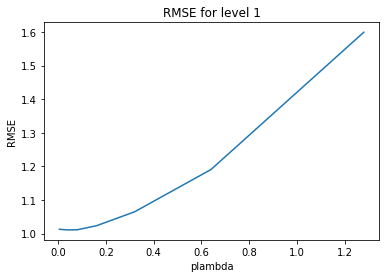

level: 2
Rating Number of level 2: 49309
Current plambda: 0.005
MF DONE
324698.588152
303366
Current RMSE: 1.03456253596
Current plambda: 0.01
MF DONE
314319.908792
303366
Current RMSE: 1.01789385433
Current plambda: 0.02
MF DONE
306668.670503
303366
Current RMSE: 1.00542864109
Current plambda: 0.04
MF DONE
302006.841404
303366
Current RMSE: 0.997757355204
Current plambda: 0.08
MF DONE
299395.566836
303366
Current RMSE: 0.993434481669
Current plambda: 0.16
MF DONE
306720.046528
303366
Current RMSE: 1.005512857
Current plambda: 0.32
MF DONE
332499.623155
303366
Current RMSE: 1.04691669645
Current plambda: 0.64
MF DONE
416677.08651
303366
Current RMSE: 1.17196962759
Current plambda: 1.28
MF DONE
755400.003027
303366
Current RMSE: 1.57799287699
min RMSE: 0.993434481669


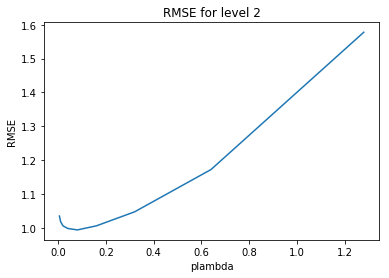

level: 3
Rating Number of level 3: 115742
Current plambda: 0.005
MF DONE
323569.224147
303349
Current RMSE: 1.03279070334
Current plambda: 0.01
MF DONE
318646.826897
303349
Current RMSE: 1.02490477204
Current plambda: 0.02
MF DONE
312689.030336
303349
Current RMSE: 1.01527814837
Current plambda: 0.04
MF DONE
305972.705199
303349
Current RMSE: 1.00431525472
Current plambda: 0.08
MF DONE
299663.08479
303349
Current RMSE: 0.993906061326
Current plambda: 0.16
MF DONE
304022.762282
303349
Current RMSE: 1.00110992385
Current plambda: 0.32
MF DONE
330221.522049
303349
Current RMSE: 1.04335332304
Current plambda: 0.64
MF DONE
414765.046474
303349
Current RMSE: 1.16931034288
Current plambda: 1.28
MF DONE
756137.632727
303349
Current RMSE: 1.57880736197
min RMSE: 0.993906061326


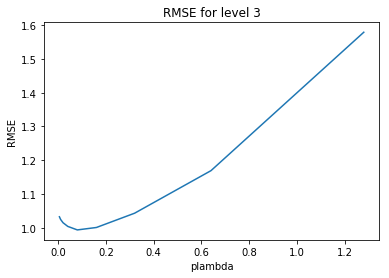

level: 4
Rating Number of level 4: 231579
Current plambda: 0.005
MF DONE
318425.175686
303336
Current RMSE: 1.02457020156
Current plambda: 0.01
MF DONE
314069.534678
303336
Current RMSE: 1.01753868137
Current plambda: 0.02
MF DONE
308876.488835
303336
Current RMSE: 1.00909126804
Current plambda: 0.04
MF DONE
302294.410651
303336
Current RMSE: 0.998281633181
Current plambda: 0.08
MF DONE
295937.8169
303336
Current RMSE: 0.98773002374
Current plambda: 0.16
MF DONE
301987.82886
303336
Current RMSE: 0.997775284736
Current plambda: 0.32
MF DONE
327244.840897
303336
Current RMSE: 1.03866243876
Current plambda: 0.64
MF DONE
409796.619603
303336
Current RMSE: 1.16231062552
Current plambda: 1.28
MF DONE
746354.790622
303336
Current RMSE: 1.5685944881
min RMSE: 0.98773002374


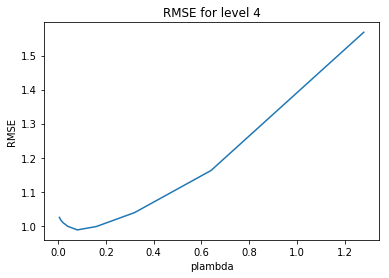

In [170]:
prediction_model = {}
rmst_dict = {"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[],"10":[]}
for level in range(depth_threshold + 1):
    level = str(level)
    print("level:", level)
    prediction_model.setdefault(level, {})
    train_lst = []       
    for pseudo_user_bound, userid in zip(lr_bound[level], range(len(lr_bound[level]))):
        if pseudo_user_bound[0] > pseudo_user_bound[1]:
            continue
        pseudo_user_lst = tree[pseudo_user_bound[0]:(pseudo_user_bound[1] + 1)]
        ratings_Pseudo_u2i = np.array(rating_matrix_csc_train[:, pseudo_user_lst].sum(axis=1))[:,0] / \
                                     (rating_matrix_csc_train[:, pseudo_user_lst].getnnz(axis=1)+1e-9)
        train_lst += [(userid, itemid, float(ratings_Pseudo_u2i[itemid])) \
                      for itemid in range(ratings_Pseudo_u2i.shape[0]) if ratings_Pseudo_u2i[itemid]]        

    print("Rating Number of level " + level + ": " + str(len(train_lst)))
    
    #### Train MF and Do validation ####
    min_RMSE = -1
    user_profile_list = []
    item_profile_list = []
    for plambda in lambda_list:
        print("Current plambda: " + str(plambda))
        MF.change_parameter(plambda)
        user_profile, item_profile = MF.matrix_factorization(train_lst)
        user_profile_list.append(user_profile)
        item_profile_list.append(item_profile)
        prediction_model[level]['upro'], prediction_model[level]['ipro'], prediction_model[level]['plambda'] \
                                         = user_profile, item_profile, plambda
        rmse = 0
        rmseNum = 0
        for userid in range(rating_matrix_csc_test.shape[1]):
    #         if userid % 100 == 0:
    #             print("%.2f%%" % (100 * userid / rating_matrix_csc_test.shape[1]))  
            pred_index = 0
            final_level = 0
            rated_item = []
            user_all_ratings = rating_matrix_csc_test[:,userid].nonzero()[0]
            for depth in range(int(level)):
                if split_item[depth][pred_index] not in user_all_ratings:
                    tmp_pred_index = 3*pred_index + 2
                    if tmp_pred_index in prediction_model[str(int(depth)+1)]['upro']:
                        final_level += 1
                        pred_index = tmp_pred_index
                    else:
                        break
                elif rating_matrix_csc_test[split_item[depth][pred_index], userid] > 3:
                    tmp_pred_index = 3*pred_index
                    if tmp_pred_index in prediction_model[str(int(depth)+1)]['upro']:
                        rated_item.append(split_item[depth][pred_index][0]-1)
                        final_level += 1
                        pred_index = tmp_pred_index
                    else:
                        break
                elif rating_matrix_csc_test[split_item[depth][pred_index], userid] <= 3:
                    tmp_pred_index = 3*pred_index + 1
                    if tmp_pred_index in prediction_model[str(int(depth)+1)]['upro']:
                        rated_item.append(split_item[depth][pred_index][0]-1)
                        final_level += 1
                        pred_index = tmp_pred_index
                    else:
                        break   
                        
            pred_rating = np.dot(np.array(prediction_model[str(final_level)]['upro'][pred_index]), \
                                 np.array(list(prediction_model[str(final_level)]['ipro'].values())).T) 
            real_rating = rating_matrix_csc_test[:, userid].toarray()
            non_zeros = list(np.nonzero(real_rating)[0])
            non_zeros = list(set(non_zeros).difference(set(rated_item)))
            non_zerosNum = pred_rating[non_zeros].shape[1]
            rmse += np.sum((pred_rating[non_zeros].T.reshape(non_zerosNum, 1)-real_rating[non_zeros])**2)
            rmseNum += len(non_zeros)
        RMSE = (rmse/rmseNum)**0.5
        print(rmse)
        print(rmseNum)
        print("Current RMSE: " + str(RMSE))
        rmst_dict[level].append(RMSE)
    min_MF = rmst_dict[level].index(min(rmst_dict[level]))   
    prediction_model[level]['upro'] = user_profile_list[min_MF]
    prediction_model[level]['ipro'] = item_profile_list[min_MF]
    prediction_model[level]['plambda'] = lambda_list[min_MF]
    print("min RMSE: " + str(min(rmst_dict[level])))
    plt.figure(1)
    plt.title('RMSE for level ' + level)
    plt.xlabel('plambda')
    plt.ylabel('RMSE')
    plt.plot(lambda_list, rmst_dict[level])
    plt.show()

In [171]:
MF.end()

SparkSession stopped.


In [ ]:
import klepto
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)
Tree['prediction_model'] = prediction_model
Tree.dump()
Tree.clear()

In [172]:
min_rmse_list = [1.02888810294, 
                 1.01108332722,
                 0.993434481669,
                 0.993906061326,
                 0.98773002374]

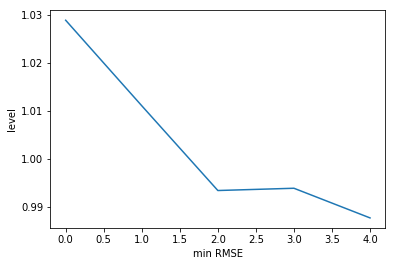

In [175]:
plt.figure(1)
plt.xlabel('min RMSE')
plt.ylabel('level')
plt.plot(list(range(5)), min_rmse_list)
plt.show()

In [65]:
treal_rating = rating_matrix_csc_test[:, 1].toarray()

In [66]:
non_zeros = list(np.nonzero(treal_rating)[0])

In [68]:
non_zeros = list(set(non_zeros).difference(set([])))

In [70]:
t=rating_matrix_csc_test[:,1].nonzero()[0]

In [80]:
pred_rating = np.dot(np.array(prediction_model["0"]['upro'][0]), \
                     np.array(list(prediction_model["0"]['ipro'].values())).T) 

In [81]:
pred_rating

array([ 4.08449802,  3.77205881,  3.94233877, ...,  3.91949047,
        3.88800869,  3.53263267])

In [83]:
np.array(list(prediction_model["0"]['ipro'].values())).T.shape

(10, 6040)

In [ ]:
np.multiply(np.ones(rating_matrix_csc_test.shape) * 3.5839332018605505, rating_matrix_csc_test!=0)

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 55746)
Traceback (most recent call last):
  File "/home/zhaozihan/miniconda3/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/zhaozihan/miniconda3/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/home/zhaozihan/miniconda3/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/zhaozihan/miniconda3/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/spark/spark-2.2.0-bin-hadoop2.6/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/usr/lib/spark/spark-2.2.0-bin-hadoop2.6/python/pyspark/serializers.py", line 577, in read_int
    raise EOFError
EOFError
-----------------

{0: [0.19403712451457977,
  0.0832921639084816,
  0.6274546384811401,
  -0.42187848687171936,
  -0.30671998858451843,
  0.11419331282377243,
  0.29262134432792664,
  -0.5510282516479492,
  0.1493316888809204,
  0.05447138473391533]}

In [48]:
real_rating

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [ ]:

rating_matrix_csc_test